<a id="topV"></a>

# ViewData.ipynb
#### Nat Kerman (nkerman@stsci.edu)

# Learning Goals
### This Notebook is designed to walk the user (*you*) through:
- **Downloading Existing Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) data from the online archive**
- **Reading in the data using `Python`**
- **Displaying the data using common plotting techniques**

# Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to begin analyzing COS data of your choice by walking you through downloading, reading, and viewing a spectrum obtained with COS.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).



>*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## We will import the following packages:

- numpy to handle array functions
- astropy.io fits for accessing FITS files
- astropy.table Table for creating tidy tables of the data
- matplotlib.pyplot for plotting data
- astroquery.mast Mast and Observations for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive

In [1]:
%matplotlib inline

colors = ['#e9dcb4', '#cec191']

import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs


# 1. Downloading the Data

One can search for COS data from both a browser-based gui and a command-line `Python` library.

##### *A more in-depth MAST archive tutorial can be found [here](https://mast.stsci.edu/api/v0/MastApiTutorial.html).*


## 1.1 The MAST Web Search
A browser gui for searching HST archival data can be found [here](http://archive.stsci.edu/hst/search.php).

The search page is laid out as in fig. 1.1:
### Fig 1.1
<center><img src=figures/Mast_hst_searchform3.png width ="900" title="MAST Archive search form for a COS data query"> </center>

where here we have indicated we would like to find all archival data from the **COS near-ultraviolet configuration science** data, taken with the **G230L grating** while looking at **stars**. The output columns we have selected to see are visible in the bottom left of Fig 1.1.

Note that if you have a list of coordinates, Observation ID(s), etc. you can click on the "File Upload Form" and attach your list of OBSIDs or identifying features. Then specify which type of data your list contains using the "File Contents" drop-down menu.

Figure 1.2 shows the *long* results of our search.
### Fig 1.2
<center><img src=figures/mast_hst_searchRes.png width ="900" title="MAST Archive search results for a COS data query"> </center>


#### We now choose our dataset.
We *arbitrarily* select LBBD01020, taken under an calibration program described as:
> "NUV Spectroscopic Sensitivity Monitoring"

This is a white dwarf star  known as [WD1057+719](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=WD1057%2B719&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id)

Clicking on the dataset, we are taken to a page displaying a preview spectrum (Fig 1.3).
### Fig 1.3

<center><img src=./figures/preview_spec1.png width ="900" title="MAST Archive preview spectrum of LBBD01020"> </center>

We now return to the [search page](http://archive.stsci.edu/hst/search.php) and enter in LBBD01020 under "Dataset" with no other parameters set. Hitting search, now we see a single-rowed table with just our dataset, and *crucially* the option to download datasets. We mark the row we wish to download and click "Submit marked data for retrieval from STDADS". See Fig 1.4.

### Fig. 1.4

<center><img src=figures/LBBD01020_res.png width ="900" title="MAST Archive dataset overview of LBBD01020"> </center>

Now we see a page like in Fig 1.5, where we can either sign in with STScI credentials, or simply provide our email to proceed (relatively) anonymously. Make sure to select "Deliver the data to the Archive staging area". Hit "Send Retrieval Request to STDADS" and you will recieve an email with instructions on downloading with ftp. You will need to do this step from the command line.

In the case of this request, the command to retrieve the data was:
>`wget -r --ftp-user=anonymous --ask-password ftps://archive.stsci.edu/stage/anonymous/anonymous42822`

where the password was the email address used. Now all the data is in a subdirectory "/archive.stsci.edu/stage/anonymous/anonymous42822/"

### Done!


## 1.2 astroquery.mast
Another way to search for and download archived datasets is within `Python` using the module [`astroquery.mast`](https://astroquery.readthedocs.io/en/latest/mast/mast.html). We have already imported 2 of this module's key tools: `Observations` and `Mast`.

There are *many* options for searching the archive with astroquery, but we will begin with a very general search using the coordinates we found in the last section to find the same dataset. 
- Our coordinates were:      (11:00:34.126 +71:38:02.80). 
    - We can search these coordinates as sexagesimal coordinates, or convert them to decimal degrees.

In [4]:
query_1 = Observations.query_object("11:00:34.126 +71:38:02.80", radius="5 sec")

This command has generated a table of objects called **"query_1"**. We can see what information we have on the objects in the table by printing its *`keys`*, and see how many objects are in the table with `len(query_1)`.

In [5]:
print(f"We have table information on {len(query_1)} observations in the following categories/columns:\n")
(query_1.keys())

We have table information on 708 observations in the following categories/columns:



['intentType',
 'obs_collection',
 'provenance_name',
 'instrument_name',
 'project',
 'filters',
 'wavelength_region',
 'target_name',
 'target_classification',
 'obs_id',
 's_ra',
 's_dec',
 'dataproduct_type',
 'proposal_pi',
 'calib_level',
 't_min',
 't_max',
 't_exptime',
 'em_min',
 'em_max',
 'obs_title',
 't_obs_release',
 'proposal_id',
 'proposal_type',
 'sequence_number',
 's_region',
 'jpegURL',
 'dataURL',
 'dataRights',
 'mtFlag',
 'srcDen',
 'obsid',
 'distance']

Now we narrow down a bit with some additional parameters (wavelength_region,instrument_name and configuration, dataproduct_type):

In [13]:
query_2 = Observations.query_criteria(s_ra=[165., 166.], s_dec=[+71.,+72.],
                                        wavelength_region="UV", instrument_name="COS/NUV", 
                                        dataproduct_type = "spectrum")
query_2

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str8,int64,str3,str9,str10,float64,float64,float64,float64,float64,str2,str5,float64,float64,str7,str50,float64,str7,str19,str5,str7,str3,int64,str6,str47,str37,str38,str6,bool,float64,str7,str10,str10
spectrum,3,HST,le0sl2020,WD1057+719,165.1417487528,71.63404952112,59062.99029997,59063.00013793,850.208,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59064.04225,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174867 71.63404945 0.00069444,mast:HST/product/le0sl2020_x1dsum.png,mast:HST/product/le0sl2020_x1dsum.fits,PUBLIC,False,nan,science,2008158631,2048961109
spectrum,3,HST,le0sl2010,WD1057+719,165.1417487537,71.63404952125,59062.98133032,59062.98758032,540.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.2483,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,mast:HST/product/le0sl2010_x1dsum.png,mast:HST/product/le0sl2010_x1dsum.fits,PUBLIC,False,nan,science,2008158537,2048960143
spectrum,1,HST,le0sl2h7q,WD1057+719,165.1417487541,71.6340495213,59062.97992515,59062.97993325,0.7,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.24816,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,--,mast:HST/product/le0sl2h7q_rawacq.fits,PUBLIC,False,nan,science,2008158485,2048960082
spectrum,1,HST,le0sl2h6q,WD1057+719,165.1417487542,71.63404952132,59062.97652998,59062.97742115,77.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.24814,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,--,mast:HST/product/le0sl2h6q_rawacq.fits,PUBLIC,False,nan,science,2008158489,2048960085
spectrum,1,HST,le0sl2h5q,WD1057+719,165.1417487549,71.63404952141,59062.96944807,59062.97560547,532.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.2481,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,--,mast:HST/product/le0sl2h5q_rawacq.fits,PUBLIC,False,nan,science,2008158486,2048960083
spectrum,3,HST,le0sl1020,WD1057+719,165.1417703905,71.63405248633,58868.04901551,58868.05885347,850.176,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,58868.53459,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14177054 71.63405255 0.00069444,mast:HST/product/le0sl1020_x1dsum.png,mast:HST/product/le0sl1020_x1dsum.fits,PUBLIC,False,nan,science,2008129527,2048957350
spectrum,3,HST,le0sl1010,WD1057+719,165.1417703914,71.63405248645,58868.04004552,58868.04629552,540.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,58868.53442,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14177054 71.63405255 0.00069444,mast:HST/product/le0sl1010_x1dsum.png,mast:HST/product/le0sl1010_x1dsum.fits,PUBLIC,False,nan,science,2008129526,2048950327
spectrum,1,HST,le0sl1a9q,WD1057+719,165.1417703918,71.63405248651,58868.03864071,58868.03864881,0.7,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,58868.46453,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14177054 71.63405255 0.00069444,--,mast:HST/product/le0sl1a9q_rawacq.fits,PUBLIC,False,nan,science,2008129472,2048956948
spectrum,1,HST,le0sl1a8q,WD1057+719,165.1417703919,71.63405248652,58868.03524514,58868.03613634,77.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,58868.46453,COS/NUV,

#### Caution! 
<img src=figures/warning.png width ="60" title="MAST Archive preview spectrum of LBBD01020"> 
Please note that these queries are Astropy tables and do not always respond as expected for other data structures like Pandas DataFrames. For instance, the first way of filtering a table shown below is correct, but the second will consistently produce the *wrong result*.

In [19]:
# Searching a table generated with a query
## First correct way using masking
mask = (query_1['obs_id'] == 'lbbd01020')
print("Correct way yields: \n" , query_1[mask]['obs_id'],"\n\n")

# Second incorrect way
print("Incorrect way yields: \n" , query_1['obs_id' == 'LBBD01020']['obs_id'])

Correct way yields: 
   obs_id 
---------
lbbd01020 


Incorrect way yields: 
 tess-s0014-4-3


### Now we can choose download our data products from the archive dataset.

We will first generate a list of data products in the dataset: `product_list`. Then we will download *just the* **minimum recommended products**, which are the fully calibrated spectrum (denoted by the suffix `_x1d` or here `x1dsum`) and the association file (denoted by the suffix `_asn`).

In [297]:
product_list = Observations.get_product_list(query_2)
product_list

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str3,str8,str9,str62,str1,str44,str9,str28,str9,str1,str6,str5,str5,str27,int64,str10
2007688613,HST,spectrum,ldlm42010,DADS JIF file,C,mast:HST/product/ldlm42010_jif.fits,AUXILIARY,--,JIF,--,CALCOS,--,15071,ldlm42010_jif.fits,34560,2007688613
2007688613,HST,spectrum,ldlm42010,DADS JIT file,C,mast:HST/product/ldlm42010_jit.fits,AUXILIARY,--,JIT,--,CALCOS,--,15071,ldlm42010_jit.fits,118080,2007688613
2007688613,HST,spectrum,ldlm42010,DADS TRL file - Processing log,C,mast:HST/product/ldlm42010_trl.fits,AUXILIARY,--,TRL,--,CALCOS,--,15071,ldlm42010_trl.fits,20160,2007688613
2007688613,HST,spectrum,ldlm42010,DADS X3S file - Summed 1D spectrum COS,C,mast:HST/product/ldlm42010_x1dsum3.fits,AUXILIARY,--,X1DSUM3,--,CALCOS,3.3.9,15071,ldlm42010_x1dsum3.fits,198720,2007688613
2007688613,HST,spectrum,ldlm42010,DADS ASN file - Association ACS/WFC3/STIS,C,mast:HST/product/ldlm42010_asn.fits,AUXILIARY,Minimum Recommended Products,ASN,--,CALCOS,3.3.9,15071,ldlm42010_asn.fits,11520,2007688613
2007688613,HST,spectrum,ldlm42010,DADS XSM file - Calibrated combined extracted 1D spectrum COS,C,mast:HST/product/ldlm42010_x1dsum.fits,SCIENCE,Minimum Recommended Products,X1DSUM,--,CALCOS,3.3.9,15071,ldlm42010_x1dsum.fits,198720,2007688613
2007688613,HST,spectrum,ldlm42010,Preview-Thumb,C,mast:HST/product/ldlm42010_x1dsum_thumb.png,THUMBNAIL,--,--,--,CALCOS,3.3.9,15071,ldlm42010_x1dsum_thumb.png,5477,2007688613
2007688613,HST,spectrum,ldlm42010,Preview-Thumb,C,mast:HST/product/ldlm42010_x1dsum3_thumb.png,THUMBNAIL,--,--,--,CALCOS,3.3.9,15071,ldlm42010_x1dsum3_thumb.png,5477,2007688613
2007688514,HST,spectrum,ldlm42yrq,DADS CTG file - Corrected events COS,S,mast:HST/product/ldlm42yrq_corrtag.fits,AUXILIARY,--,CORRTAG,--,CALCOS,3.3.9,15071,ldlm42yrq_corrtag.fits,102778560,2007688613


In [315]:
downloads = Observations.download_products(product_list, download_dir='./data/' , extension='fits', mrp_only=True, cache=False)
# The cache = False allows it to re-download data it still finds on the computer

## Excellent! You've now done the hardest part - finding and downloading the data. From here, it's a snap to read in and plot the spectrum.

# 2. Reading in the data

The calibrated data is now on our local machine as: `__current-working-directory__//data/mastDownload/HST/LBBD01020/LBBD01020_x1dsum.fits`

We want to learn a bit about this file, then input the data.

We can learn a great deal about our data from its primary fits header (see cell below).

In [339]:
x1d_filepath = './data/mastDownload/HST/LBBD01020/LBBD01020_x1dsum.fits'
asn_filepath = './data/mastDownload/HST/LBBD01020/LBBD01020_asn.fits'


header_x1d = fits.getheader(x1d_filepath)
header_asn = fits.getheader(asn_filepath)

header_x1d #This is the main 0th header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    1 / Number of standard extensions                  
DATE    = '2020-07-30'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'ldlm42010_x1dsum.fits' / name of file                                
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000.0 / equinox of celestial coord. system             
                            

For instance, we notice that the data was taken in [TIME-TAG mode](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data) and calibrated with calcos version `3.3.9`

However, some metadata information, such as the time of observation and calculated exposure time, can be found in the **1st header** rather than the 0th:

In [366]:
with fits.open(x1d_filepath) as hdu:
    header1_x1d = hdu[1].header
    date = header1_x1d['DATE-OBS']
    time = header1_x1d['TIME-OBS']
    exptime = header1_x1d['EXPTIME']

print(f"This data was taken on {date} starting at {time} with a net exposure time of {exptime} seconds.")

This data was taken on 2017-12-15 starting at 07:19:18 with a net exposure time of 2731.2 seconds.


In [398]:
x1d_data = fits.getdata(x1d_filepath)

(array([  2.,  16.,  52., 135., 244., 540., 170.,  76.,  31.,   8.]),
 array([-1.6029412e-14, -1.2956157e-14, -9.8829009e-15, -6.8096451e-15,
        -3.7363894e-15, -6.6313362e-16,  2.4101221e-15,  5.4833779e-15,
         8.5566337e-15,  1.1629889e-14,  1.4703145e-14], dtype=float32),
 <BarContainer object of 10 artists>)

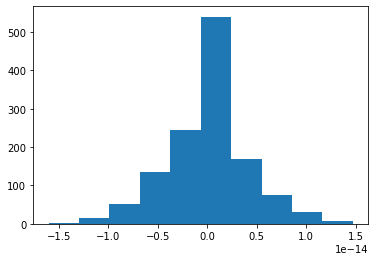

In [395]:
plt.hist(x1d_data['FLUX'][2])

In [397]:
np.shape([x1d_data['WAVELENGTH'],x1d_data['FLUX']])

(2, 3, 1274)

Text(0, 0.5, 'Flux [$erg\\ s^{-1}$]')

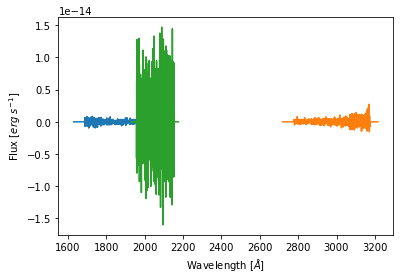

In [400]:
for i in range(3):
    plt.plot(x1d_data['WAVELENGTH'][i],x1d_data['FLUX'][i])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux [$erg\ s^{-1}$]')

In [365]:
# fits.getheader("./data/archive.stsci.edu/stage/anonymous/anonymous42773/LBBD01020_x1dsum3.fits")

[Top of Page](#topV)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

# Junk

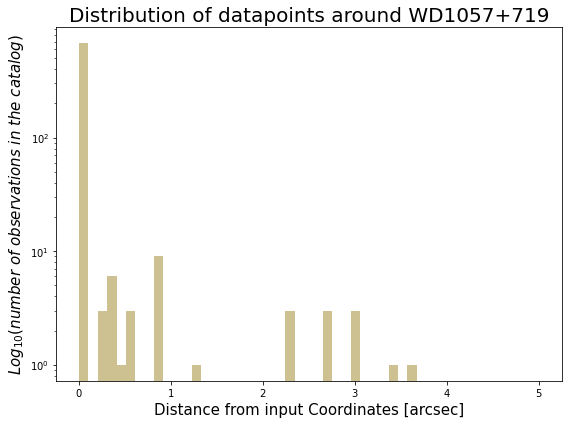

In [7]:
plt.figure(figsize=(8,6))
a,b,c = plt.hist(query_1['distance'],bins = np.linspace(0,5,50), color= colors[1], alpha = 1)
plt.yscale('log')
plt.title("Distribution of datapoints around WD1057+719", size = 20)
plt.xlabel("Distance from input Coordinates [arcsec]", size = 15)
plt.ylabel("$Log_{10}(number\ of\ observations\ in\ the\ catalog)$", size = 15)
plt.tight_layout()

That's a **lot** of observations in a 5 arcsecond radius, because TRAPPIST-1 has been very closely studied. We can significantly narrow down the results with what we know about the data.

#### Let's search for any observations in this region taken with the COS/NUV configuration, and producing a dataproduct of a spectrum: